# image reconstruction

## Import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

In [41]:
directory_data  = '/content/drive/MyDrive/2022_ml_assignment/'
filename_data   = 'assignment_11_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

clean_image_train = data['label_train']
input_image_test  = data['input_test'] 
clean_image_test  = data['label_test']

In [33]:
print(clean_image_train.shape)
print(input_image_test.shape)
print(clean_image_test.shape)

(800, 128, 128)
(400, 128, 128)
(400, 128, 128)


#Data Augmentation

In [42]:
# image augmentation을 위해 
clean_image_train_double = np.concatenate((clean_image_train, clean_image_train), axis=0)

for _ in range(2):
    clean_image_train = np.concatenate((clean_image_train, clean_image_train_double), axis=0)

print(clean_image_train.shape)

(4000, 128, 128)


## plot data

In [37]:
def plot_image(title, image):
    
    nRow = 6
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow):
        for c in range(nCol):
            k = r * nCol * 10 + c * 4 + 10
            axes[r, c].imshow(image[k], cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

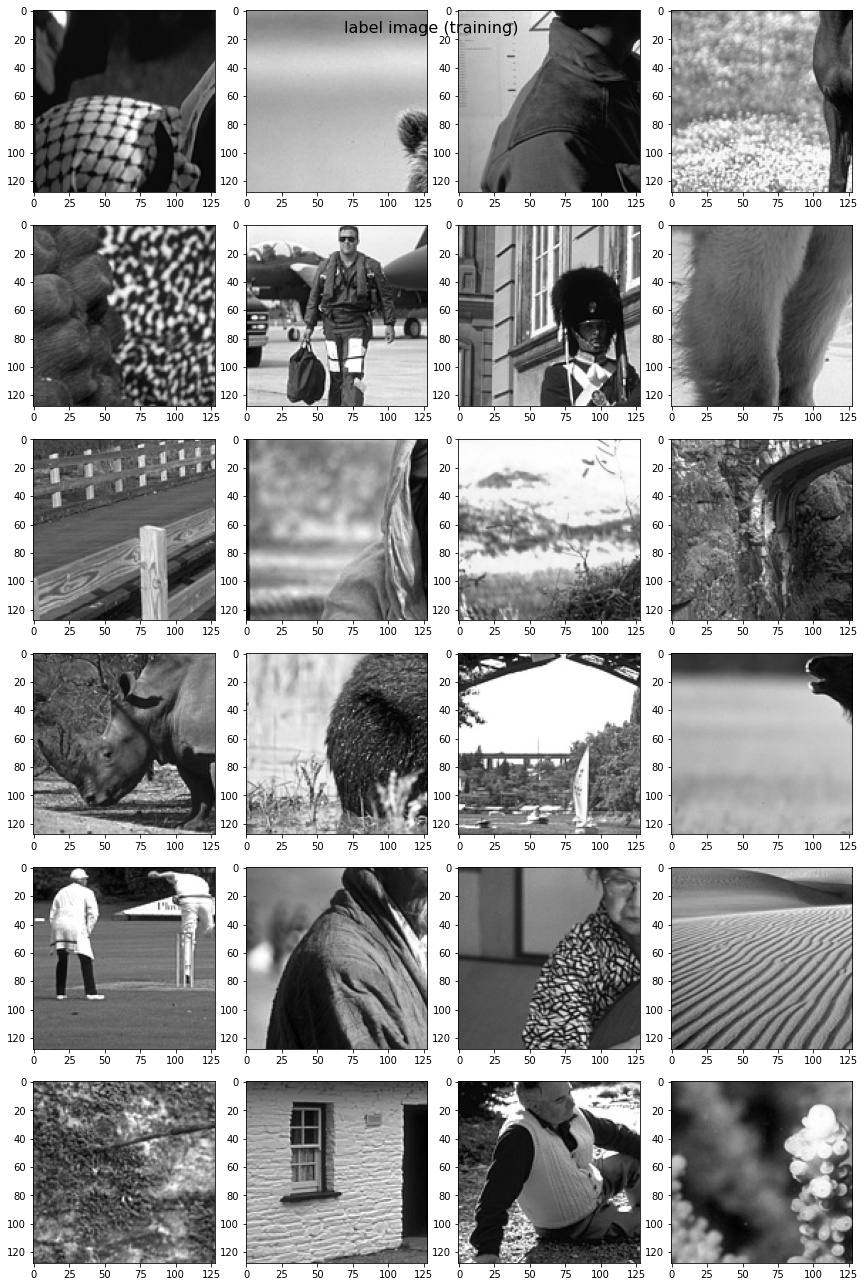

In [38]:
plot_image('label image (training)', clean_image_train)

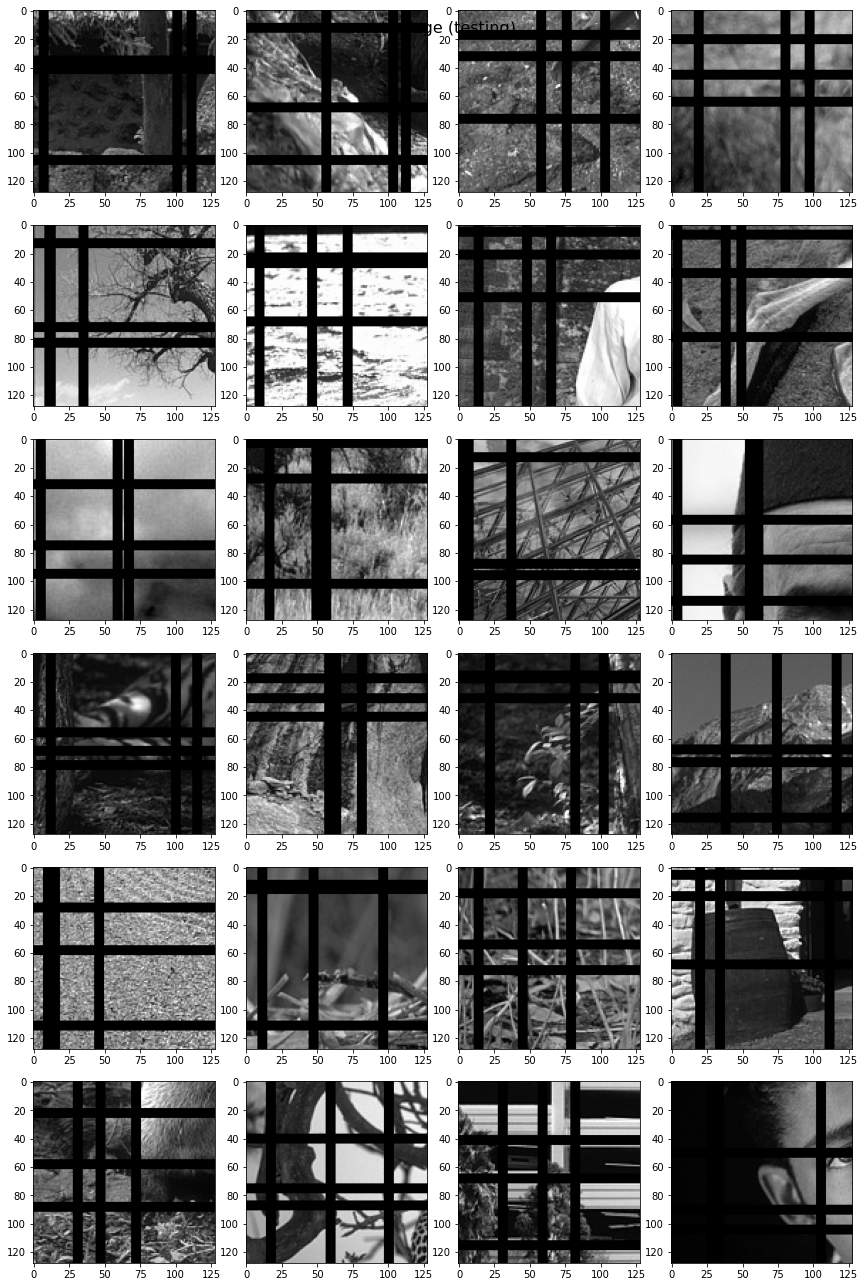

In [39]:
plot_image('input image (testing)', input_image_test)

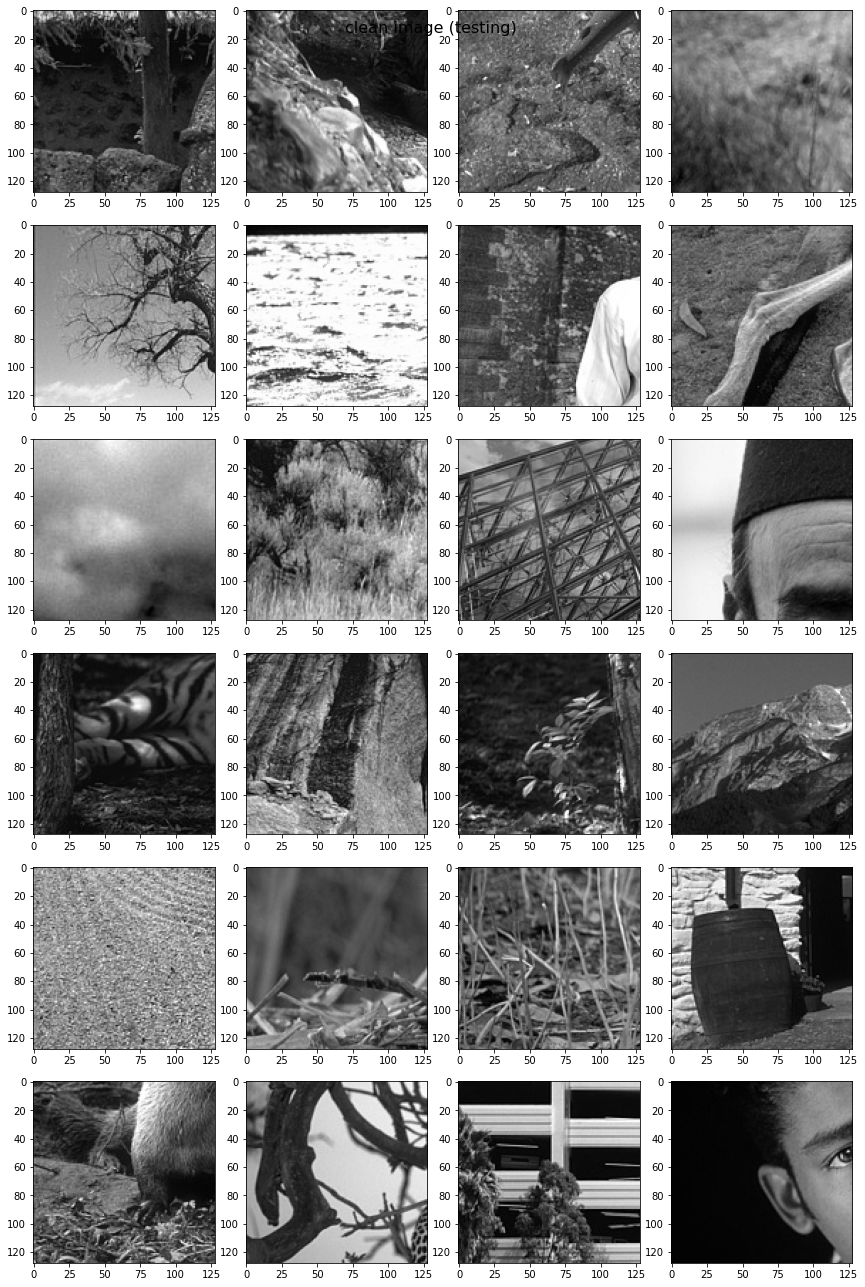

In [40]:
plot_image('clean image (testing)', clean_image_test)

In [43]:
## augmentation Definition
transforms1 = torch.nn.Sequential(
    transforms.RandomRotation(100),
)
# scripted_transforms = torch.jit.script(transformss)
transforms2 = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(p=10),
)
transforms3 = torch.nn.Sequential(
    transforms.RandomVerticalFlip(p=20)
)

transforms4 = torch.nn.Sequential(
    transforms.RandomAffine(30)
)


## custom data loader for the training data

In [9]:
class dataset(Dataset):
    
    def __init__(self, clean_image):
        
        self.clean_image = clean_image

    def __getitem__(self, index):
        # ==================================================
        # modify the codes for training data
        #        
        clean_image = self.clean_image[index]
        modified_image = clean_image.copy()
        # random integer width=6 np.random.randint(1,2)
        r1 = np.random.randint(0, 122)
        r2 = np.random.randint(0, 122)
        r3 = np.random.randint(0, 122)
        c1 = np.random.randint(0, 122)
        c2 = np.random.randint(0, 122)
        c3 = np.random.randint(0, 122)
        #row-wise
        modified_image[r1:r1+6,:] = 0
        modified_image[r2:r2+6,:] = 0
        modified_image[r3:r3+6,:] = 0
        #column-wise
        modified_image[:,c1:c1+6] = 0
        modified_image[:,c2:c2+6] = 0
        modified_image[:,c3:c3+6] = 0

        clean_image = torch.FloatTensor(clean_image).unsqueeze(dim=0)
        modified_image = torch.FloatTensor(modified_image).unsqueeze(dim=0)
        

        # ==================================================
        # data augmentation
        #     
        return (modified_image, clean_image)
        #    
        # ==================================================

    def __len__(self):

        number_image = self.clean_image.shape[0]

        return number_image    

## setting device

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [11]:
print(device)


cuda


## custom data loader for the testing data

In [12]:
input_image_test = torch.FloatTensor(input_image_test).unsqueeze(dim=1)
clean_image_test = torch.FloatTensor(clean_image_test).unsqueeze(dim=1)

input_image_test = input_image_test.to(device)
clean_image_test = clean_image_test.to(device)

In [13]:
print(input_image_test.shape)
print(clean_image_test.shape)

torch.Size([400, 1, 128, 128])
torch.Size([400, 1, 128, 128])


## construct datasets and dataloaders for training and testing

In [14]:
# ==================================================
# determine the mini-batch size
#
size_minibatch      = 100
#
# ==================================================

dataset_train       = dataset(clean_image_train)
dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)

## construct a neural network 

In [15]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------

        # Define function for redundant things
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers) # *으로 list unpacking 

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
         # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
        self.sgm = nn.Sigmoid()

        # -------------------------------------------------
        # Network
        # -------------------------------------------------

        self.initialize_weight()

    def forward(self,x):
    
        # print("11")
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)
        # print("22")
        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        # print("33")
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        # print("44")
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)
        # print("55")
        enc5_1 = self.enc5_1(pool4)
        # print("66")
        dec5_1 = self.dec5_1(enc5_1)
        # print("771")
        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
        # print("88")
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        # print("99")
        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        # print("1010")
        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        # print("1111")
        fc_out = self.fc(dec1_1)
        out = self.sgm(fc_out)        
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass

## build the network

In [16]:
model = Network().to(device)

# ==================================================
# determine the optimiser and its associated hyper-parameters
#

#loss function setting
criterion = nn.BCELoss()

learning_rate = 0.001
number_epoch = 5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#
# ==================================================

## compute the prediction

In [17]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the PSNR metric

- data1 : mini-batch-size x channel x height x width (torch tensor)
- data2 : mini-batch-size x channel x height x width (torch tensor)

In [18]:
def compute_psnr(data1, data2):

    mse         = nn.MSELoss()(data1, data2)
    mse_value   = mse.item()
    psnr        = 10 * np.log10(1 / mse_value)

    return psnr

## Variable for the learning curves

In [19]:
psnr_test = np.zeros(number_epoch)

In [20]:
loss_train_mean     = np.zeros(number_epoch)
accuracy_train_mean = np.zeros(number_epoch)


## train

In [21]:
def train(model, optimizer, dataloader):

    model.train()

    # ==================================================
    # fill up the blank
    #
    loss_epoch                  = np.zeros(8)
    accuracy_epoch              = np.zeros(8)

    for index_batch, (modified, original) in enumerate(dataloader):

        modified       = modified.to(device)
        original        = original.to(device)
        
        # ==================================================
        # fill up the blank
        #
        prediction  = compute_prediction( model, modified )
        
        loss_value = criterion(prediction, original)
        accuracy = compute_psnr(prediction, original)

        loss_epoch[index_batch] = loss_value
        accuracy_epoch[index_batch] = accuracy

        
        #
        # ==================================================

        # update the model    
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
    loss_mean   = loss_epoch.mean()
    accuracy_mean   = accuracy_epoch.mean()
    return (loss_mean, accuracy_mean)



## test

In [22]:
def test(model, input_image, clean_image):

    model.eval()

    num_steps   = 40
    steps       = np.linspace(0, input_image.shape[0], num_steps+1).astype(int)
    psnr_steps  = np.zeros(num_steps)
    
    for i in range(num_steps):
        input           = input_image[steps[i]:steps[i+1], :, :, :]
        clean           = clean_image[steps[i]:steps[i+1], :, :, :]
        prediction      = compute_prediction(model, input)
        psnr_steps[i]   = compute_psnr(clean, prediction)
    
    psnr = psnr_steps.mean()
    
    return psnr

## train and test

In [23]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_m, accuracy_m) = train(model, optimizer, dataloader_train)
    loss_train_mean[i]  = loss_m
    accuracy_train_mean[i]  = accuracy_m

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    psnr            = test(model, input_image_test, clean_image_test)
    psnr_test[i]    = psnr

100%|██████████| 5/5 [01:02<00:00, 12.44s/it]


# my custom presenting

In [24]:
def function_result_00():
    
    title           = 'loss (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
    # plt.fill_between(range(len(loss_train_mean)), loss_train_mean - loss_train_std, loss_train_mean + loss_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [25]:
def function_result_000():
    
    title           = 'accuracy (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_train_mean)), accuracy_train_mean, '-', color = color_mean)
    # plt.fill_between(range(len(accuracy_train_mean)), accuracy_train_mean - accuracy_train_std, accuracy_train_mean + accuracy_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()


################################################################################
#
# RESULT # 00
#
################################################################################



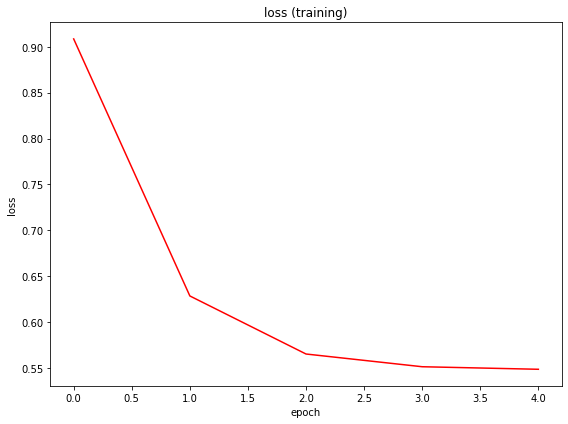

In [26]:
title           = '# RESULT # 00'
name_function   = 'function_result_00()'

print('') 
print('################################################################################')
print('#') 
print(title)
print('#') 
print('################################################################################')
print('') 

eval(name_function)


################################################################################
#
# RESULT # 000
#
################################################################################



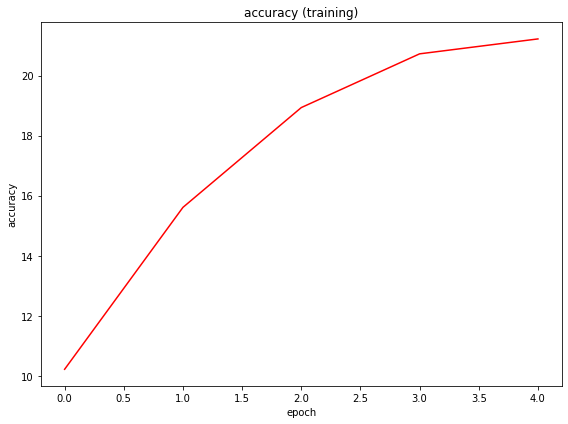

In [27]:
title           = '# RESULT # 000'
name_function   = 'function_result_000()'

print('') 
print('################################################################################')
print('#') 
print(title)
print('#') 
print('################################################################################')
print('') 

eval(name_function)

---

## functions for presenting the results

---

In [28]:
def function_result_01():
    
    title           = 'psnr (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(psnr_test, '-')
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [29]:
def function_result_02():
   
    nRow = 9
    nCol = 4
    size = 3
   
    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    model.eval()

    num_test = 12

    input_image         = input_image_test[0:num_test]
    clean_image         = clean_image_test[0:num_test]
    prediction_image    = compute_prediction(model, input_image)
   
    input_image         = input_image.detach().cpu().squeeze(axis=1)
    clean_image         = clean_image.detach().cpu().squeeze(axis=1)
    prediction_image    = prediction_image.detach().cpu().squeeze(axis=1)

    nStep   = 3
    t       = 0
   
    for r in range(3):
        for c in range(nCol):
            k = r * nCol * 10 + c * 4 + 10
           
            input       = input_image[t].detach().cpu().squeeze(axis=1)
            clean       = clean_image[t].detach().cpu().squeeze(axis=1)
            prediction  = prediction_image[t].detach().cpu().squeeze(axis=1)
           
            axes[0 + r * nStep, c].imshow(input, cmap='gray')
            axes[1 + r * nStep, c].imshow(clean, cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(prediction, cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
           
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)
           
            t = t + 1
   
    plt.tight_layout()
    plt.show()

In [30]:
def function_result_03():
    
    print('final testing psnr = %9.8f' % (psnr_test[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



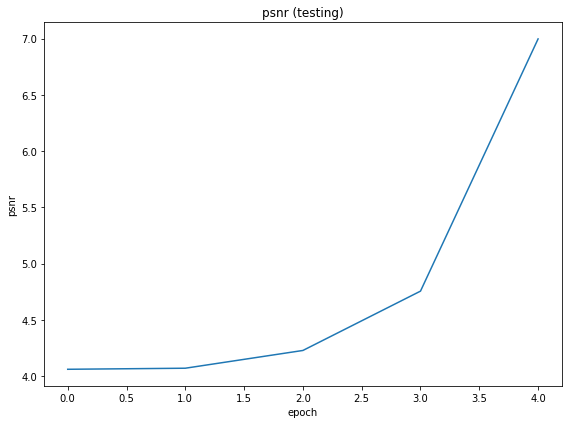


################################################################################
#
# RESULT # 02
#
################################################################################



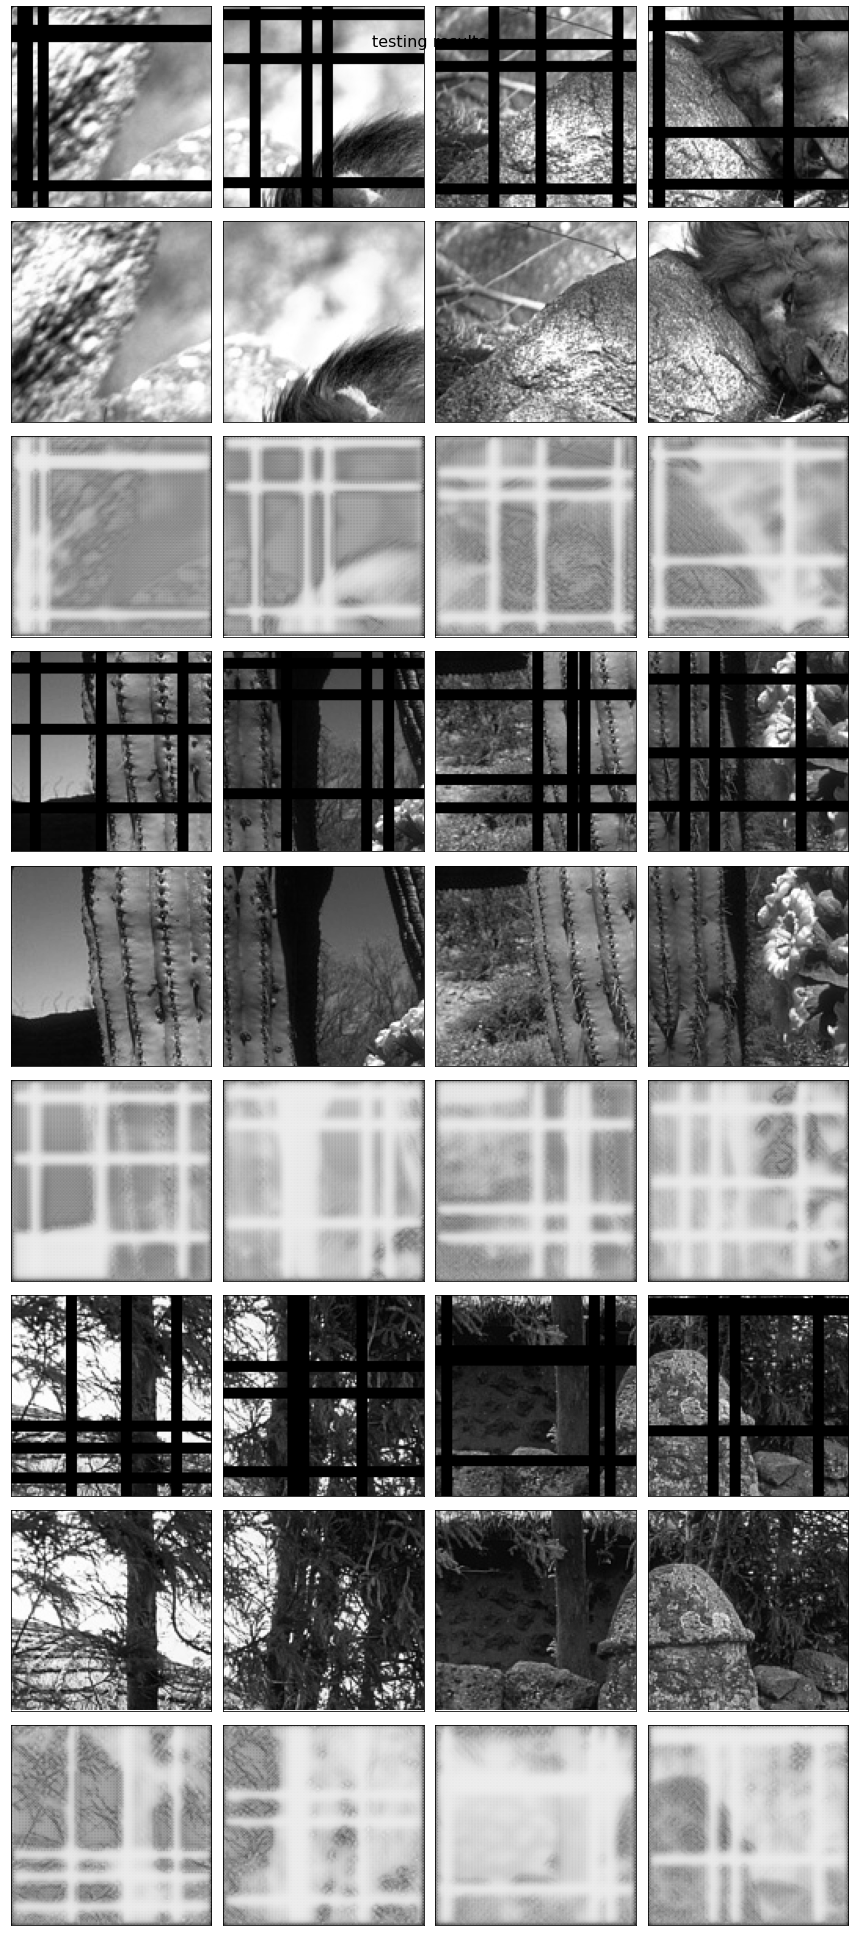


################################################################################
#
# RESULT # 03
#
################################################################################

final testing psnr = 6.99632231


In [31]:
number_result = 3 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1)
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)